## Importing the relevant libraries

In [4]:
!pip install wget

In [5]:
!pip install tensorflow==2.10.0

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from wordcloud import WordCloud
# wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, punct, remove_digits, remove_links, remove_special_characters, remove_, removeStopWords, lower, email_address, non_ascii
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the train, test and evaluation datasets

In [7]:
train_df = pd.read_csv("/kaggle/input/fake-news-classification/train (2).csv",delimiter=';')
train_df.drop('Unnamed: 0',axis=1,inplace=True)
train_df.head()

,title,text,label
0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [8]:
train_df.shape

(24353, 3)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24353 non-null  object
 1   text    24353 non-null  object
 2   label   24353 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 570.9+ KB


In [10]:
train_df.describe()

,label
count,24353.000000
mean,0.543917
std,0.498078
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
train_df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [12]:
train_df.duplicated().sum()

1

In [13]:
train_df = train_df.drop_duplicates()
train_df.shape

(24352, 3)

In [14]:
test_df = pd.read_csv('/kaggle/input/fake-news-classification/test (1).csv',delimiter=';')
test_df.drop('Unnamed: 0',axis=1,inplace=True)
test_df.head()

,title,text,label
0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1
1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1
2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1
3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1
4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1


In [15]:
test_df.shape

(8117, 3)

In [16]:
test_df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [17]:
test_df.duplicated().sum()

0

In [18]:
evaluation_df = pd.read_csv("/kaggle/input/fake-news-classification/evaluation.csv",delimiter=';')
evaluation_df.drop('Unnamed: 0',axis=1,inplace=True)
evaluation_df.head()

,title,text,label
0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [19]:
evaluation_df.shape

(8117, 3)

In [20]:
evaluation_df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [21]:
evaluation_df.duplicated().sum()

0

## Data Exploration

In [22]:
train_df['num_words'] = train_df.text.apply(len)
train_df.num_words.describe()

count    24352.000000
mean      2501.363789
std       2114.069417
min          1.000000
25%       1301.000000
50%       2224.000000
75%       3130.250000
max      48835.000000
Name: num_words, dtype: float64

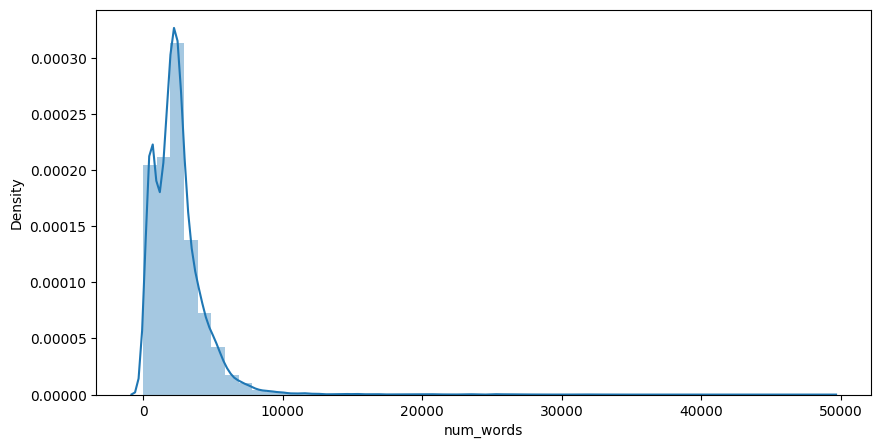

In [23]:
plt.figure(figsize=(10,5))
sns.distplot(train_df['num_words']);

In [24]:
max_len = 120

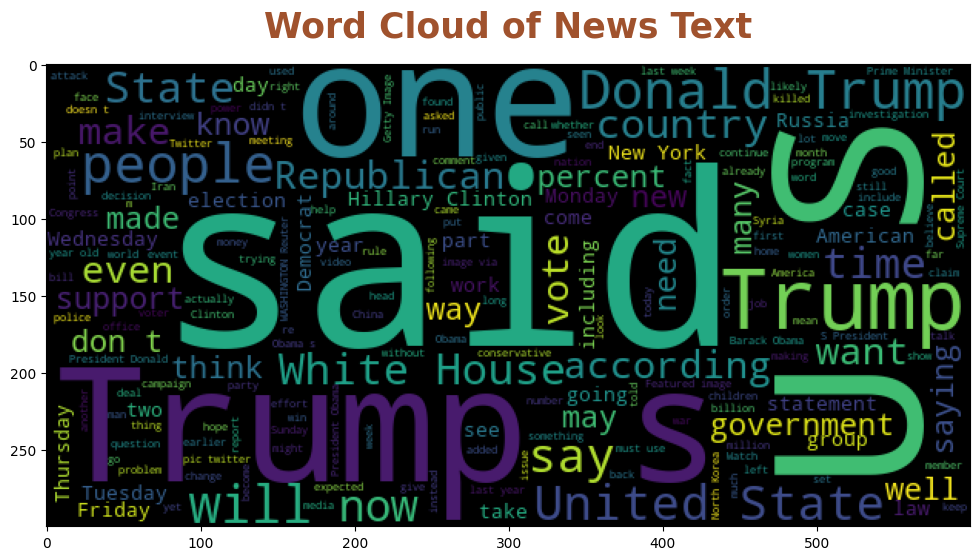

In [25]:
plt.figure(figsize=(12,6))
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(train_df.text))
plt.imshow(wc)
plt.title('Word Cloud of News Text',fontsize=25,pad=20,fontweight='bold',color='sienna')
plt.show();

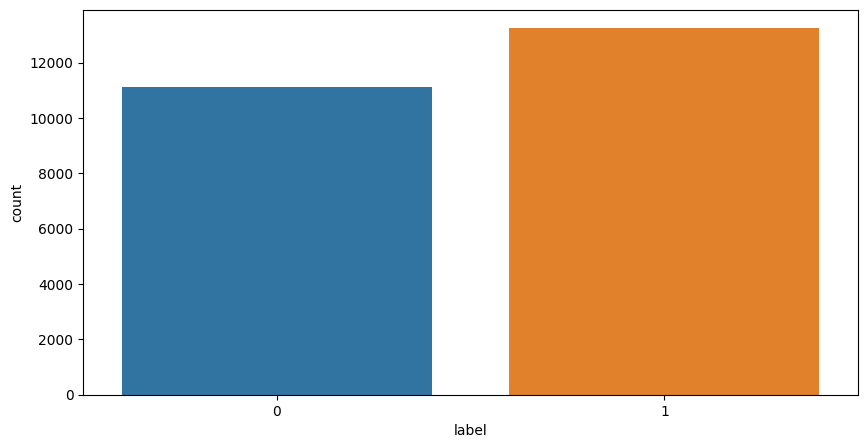

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=train_df);

The target fake news label is relatively balanced.

## Text Preprocessing

In [27]:
def preprocess_text(data,col):
    data[col] = data[col].apply(func=lower)
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    return data

In [28]:
preprocessed_train = preprocess_text(train_df,'text')
preprocessed_test = preprocess_text(test_df,'text')
preprocessed_eval = preprocess_text(evaluation_df,'text')

## Downloading pretrained Tokenizer and BERT model from Hugging Face

In [29]:
model_name = 'mrm8488/bert-tiny-finetuned-fake-news-detection'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = TFAutoModelForSequenceClassification.from_pretrained(model_name,from_pt=True)

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


## Performing text tokenization

In [30]:
X_train = tokenizer(text=preprocessed_train.text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   return_tensors='tf',
                   verbose=1)

X_test = tokenizer(text=preprocessed_test.text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  return_tensors='tf',
                  verbose=1)

X_eval = tokenizer(text=preprocessed_eval.text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  return_tensors='tf',
                  verbose=1)

## Encoding the target label classes

In [31]:
scaler = LabelEncoder()
train_df.label = scaler.fit_transform(train_df.label)
test_df.label = scaler.transform(test_df.label)
evaluation_df.label = scaler.transform(evaluation_df.label)

## Model Training & Evaluation

In [32]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [33]:
embeddings = bert(input_ids,attention_mask=attention_mask)[0] # 0 -> final hidden state, 1 -> pooling output
output = Flatten()(embeddings)
output = Dense(units=512,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.15)(output)
output = Dense(units=1,activation='sigmoid')(output)
model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 120)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  4386178    ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 2),                                                 
                                 hidden_states=None                                           

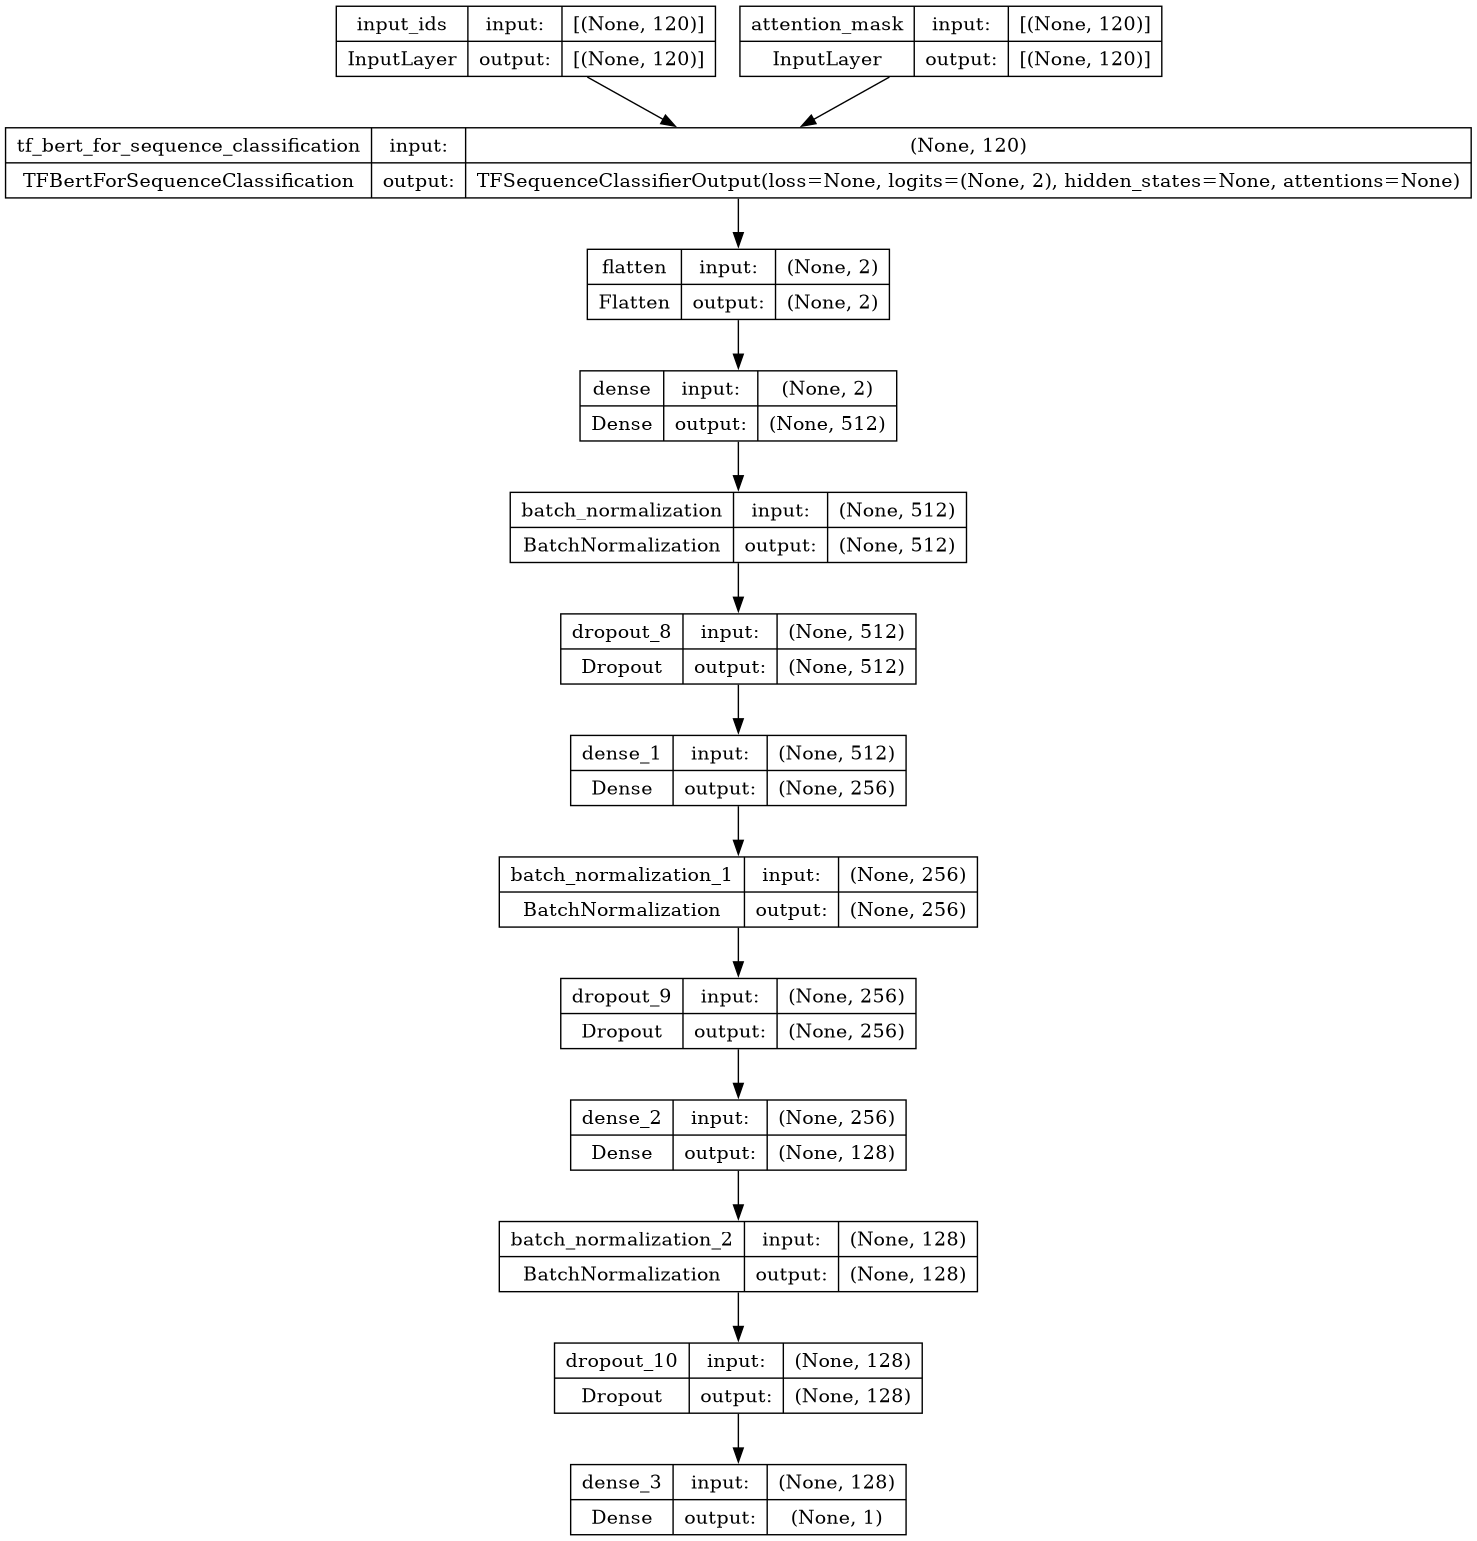

In [34]:
plot_model(model,to_file='model.png',show_shapes=True,dpi=100)

In [35]:
optimizer = Adam(learning_rate=4e-5,epsilon=1e-7,decay=1e-2,clipnorm=1.0)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [36]:
def step_decay(epoch, lr):
    drop_rate = 0.5
    step_size = 10
    return lr * drop_rate ** (epoch // step_size)

In [37]:
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=10,restore_best_weights=True,verbose=1)
lrs = LearningRateScheduler(step_decay,verbose=1)
mc = ModelCheckpoint(filepath='fake_news_classifier.keras',monitor='val_accuracy',save_best_only=True,mode='max',save_freq='epoch',verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.label,
             epochs=20,
             batch_size=256,
             callbacks=[es,lrs,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.label)
             )


Epoch 1: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 1/20
96/96 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9188
Epoch 1: val_accuracy improved from -inf to 0.94949, saving model to fake_news_classifier.keras
96/96 [==============================] - 92s 922ms/step - loss: 0.2319 - accuracy: 0.9188 - val_loss: 0.3695 - val_accuracy: 0.9495 - lr: 4.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 2/20
96/96 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9580
Epoch 2: val_accuracy improved from 0.94949 to 0.95269, saving model to fake_news_classifier.keras
96/96 [==============================] - 86s 900ms/step - loss: 0.1577 - accuracy: 0.9580 - val_loss: 0.2743 - val_accuracy: 0.9527 - lr: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 3/20
96/96 [==============================] - ETA: 0s - loss: 0.1626 -

## Visualizing model performance

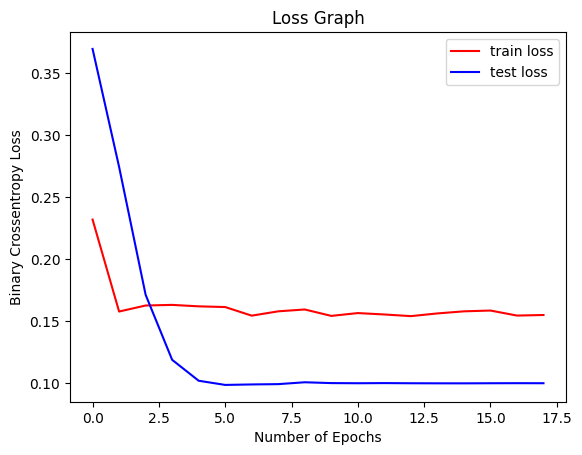

In [39]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

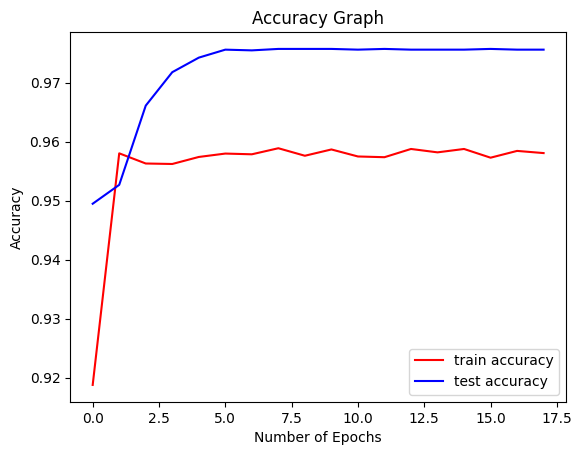

In [41]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

## Evaluating model on the test dataset

In [42]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.label)
print("Test Binary Crossentropy Loss:", round(loss,2))
print("Test Accuracy:", round(acc*100,2))

254/254 [==============================] - 15s 57ms/step - loss: 0.0992 - accuracy: 0.9757
Test Binary Crossentropy Loss: 0.1
Test Accuracy: 97.57


254/254 [==============================] - 14s 57ms/step
Confusion Matrix:
[[3686   67]
 [ 130 4234]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3753
           1       0.98      0.97      0.98      4364

    accuracy                           0.98      8117
   macro avg       0.98      0.98      0.98      8117
weighted avg       0.98      0.98      0.98      8117



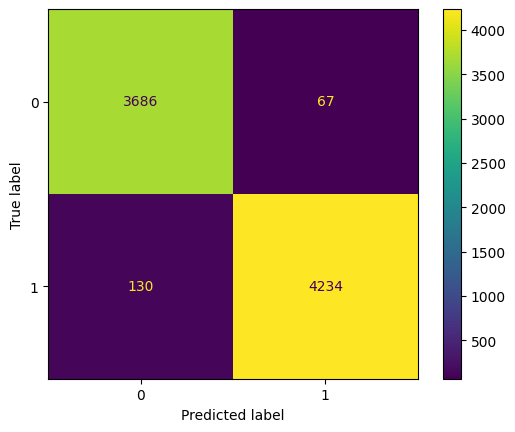

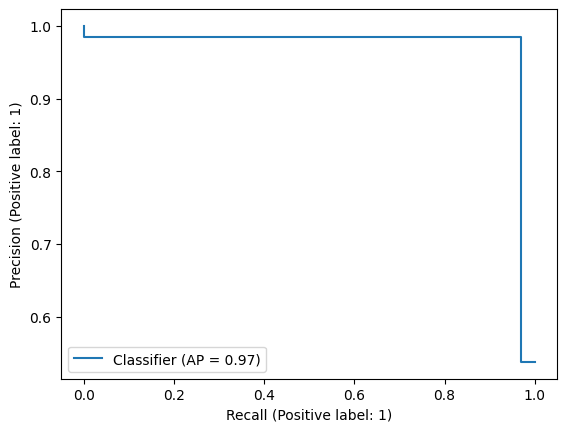

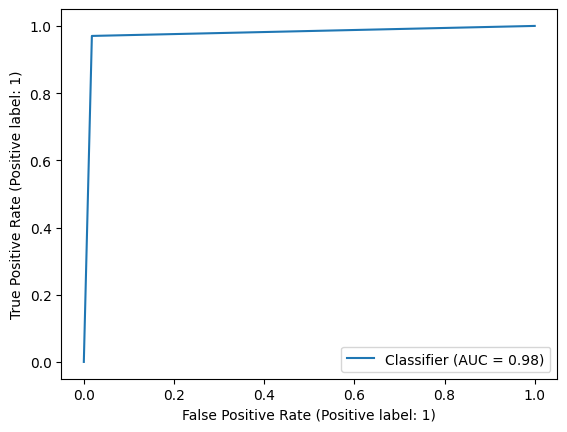

In [56]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = (test_predictions > 0.5).astype('float')
print("Confusion Matrix:")
print(confusion_matrix(test_df.label,test_predictions))
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))
ConfusionMatrixDisplay.from_predictions(test_df.label,test_predictions)
plt.show()
PrecisionRecallDisplay.from_predictions(test_df.label,test_predictions)
plt.show()
RocCurveDisplay.from_predictions(test_df.label,test_predictions)
plt.show()

## Model Inference

254/254 [==============================] - 16s 61ms/step
Confusion Matrix:
[[3733   70]
 [ 147 4167]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3803
           1       0.98      0.97      0.97      4314

    accuracy                           0.97      8117
   macro avg       0.97      0.97      0.97      8117
weighted avg       0.97      0.97      0.97      8117



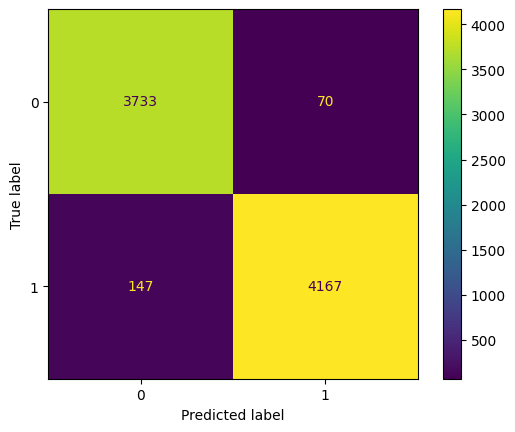

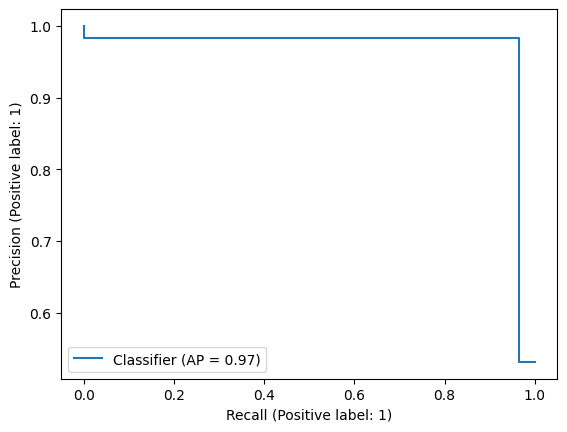

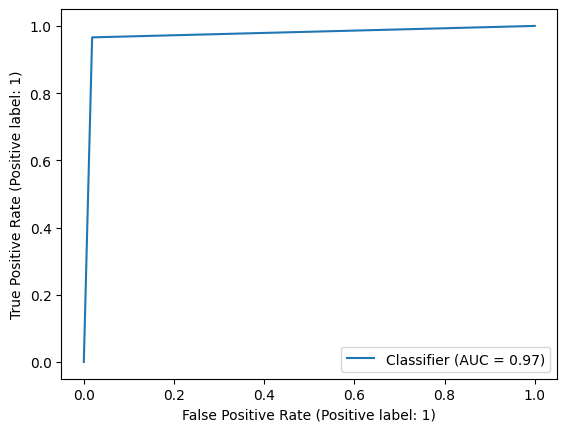

In [57]:
test_predictions = model.predict({'input_ids': X_eval['input_ids'], 'attention_mask': X_eval['attention_mask']})
test_predictions = (test_predictions > 0.5).astype('float')
print("Confusion Matrix:")
print(confusion_matrix(evaluation_df.label,test_predictions))
print("Classification Report:")
print(classification_report(evaluation_df.label,test_predictions))
ConfusionMatrixDisplay.from_predictions(evaluation_df.label,test_predictions)
plt.show()
PrecisionRecallDisplay.from_predictions(evaluation_df.label,test_predictions)
plt.show()
RocCurveDisplay.from_predictions(evaluation_df.label,test_predictions)
plt.show()

Bravo! The model has performed incredibly well by achieving an astonishing accuracy of more than 97% on the evaluation holdout set.

Don't forget to upvote my notebook if you like it! If you have any feedback, kindly share it in the comments section below.

In [62]:
tokenizer.save_pretrained(save_directory='tokenizer/') # Saving the pretrained tokenizer

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')